## Model median cost/watt as function of one feature: time (days)

### Summary of results: model_median_01

Both the weekly and daily median provide strong polynomial models with reasonable extrapolation for 6-8 quarters.  


### First we need to figure out median with respect to what....

Median is an aggregate; so what do we aggregate?
A first step would be to look at median cost/watt per time period.  Possible time periods

1. day
2. week
3. month
4. quarter
5. year

Seems like it couldn't hurt to look at plots of these.

Also I need to think about whether or not I want to group by size and state.  If I do, then the median will need to be captured over those groups as well as the time period.

First though, I want to see what the medians look like in the various time frames...

In [1]:
import datetime

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 8))
np.set_printoptions(precision=4, suppress=False)
# please show all columns
pd.set_option("display.max_columns", 60)
import seaborn as sns
sns.set()

In [3]:
# Import sklearn stuff
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

In [4]:
dfMod = pd.read_csv('../local/data/LBNL_openpv_tts_data/model_data_2.csv',
                    index_col='row_id',
                    parse_dates=['install_date'])

In [5]:
dfMod.head()

,num_days,num_weeks,num_months,size_kw,scaleSize,state,cost_per_watt,install_date
row_id,,,,,,,,
1,0.0,0.0,0.0,2.2824,0.0,CA,10.734315,1998-01-09
2,21.0,3.0,0.0,1.8504,0.0,CA,11.108701,1998-01-30
4,26.0,4.0,1.0,2.3076,0.0,CA,8.667013,1998-02-04
6,84.0,12.0,3.0,2.3316,0.0,CA,13.270286,1998-04-03
7,111.0,16.0,3.0,0.9300,0.0,CA,14.654839,1998-04-30


In [6]:
dfMod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364212 entries, 1 to 1094908
Data columns (total 8 columns):
num_days         364212 non-null float64
num_weeks        364212 non-null float64
num_months       364212 non-null float64
size_kw          364212 non-null float64
scaleSize        364212 non-null float64
state            364212 non-null object
cost_per_watt    364212 non-null float64
install_date     364212 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 25.0+ MB


### Start with days

In [7]:
by_date = dfMod.groupby(['num_days'])
med_date = by_date.cost_per_watt.median()
mean_date = by_date.cost_per_watt.mean()
print(med_date.head())
print(mean_date.head())

num_days
0.0      10.734315
21.0     11.108701
26.0      8.667013
84.0     13.270286
111.0    14.654839
Name: cost_per_watt, dtype: float64
num_days
0.0      10.734315
21.0     11.108701
26.0      8.667013
84.0     13.270286
111.0    14.654839
Name: cost_per_watt, dtype: float64


In [8]:
np.var(med_date), np.std(med_date)

(3.9052245472053655, 1.9761640992603235)

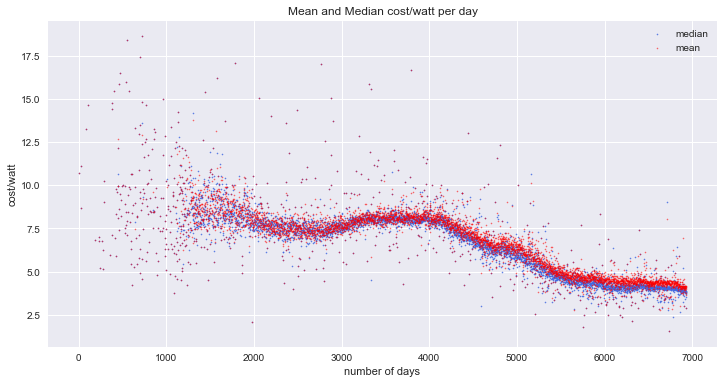

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
sTitle = 'Mean and Median cost/watt per day'

ax.set_title(sTitle)
ax.scatter(med_date.index, med_date, marker='.', color='royalblue', s=6, alpha=0.8, label='median')
ax.scatter(mean_date.index, mean_date, marker='.', color='red', s=6, alpha=0.5, label='mean')
ax.set_ylabel('cost/watt')
ax.set_xlabel('number of days')
ax.legend()

plt.show();

#### group by week

In [10]:
by_week = dfMod.groupby(['num_weeks'])
med_week = by_week.cost_per_watt.median()
mean_week = by_week.cost_per_watt.mean()

print(med_week.head())

num_weeks
0.0     10.734315
3.0     11.108701
4.0      8.667013
12.0    13.270286
16.0    14.654839
Name: cost_per_watt, dtype: float64


In [11]:
np.var(med_week), np.std(med_week)

(3.5912406357569835, 1.8950568951239917)

### Notice the difference: median is less than mean because of so much high-side noise (people overpaid).

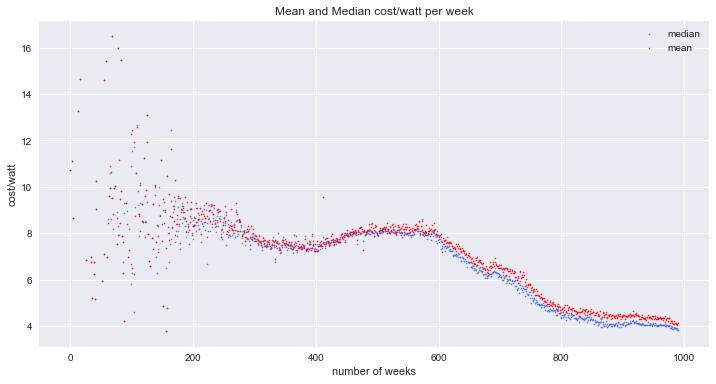

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))
sTitle = 'Mean and Median cost/watt per week'

ax.set_title(sTitle)
ax.scatter(med_week.index, med_week, marker='.', color='royalblue', s=6, alpha=0.8, label='median')
ax.scatter(mean_week.index, mean_week, marker='.', color='red', s=6, alpha=0.8, label='mean')
ax.set_ylabel('cost/watt')
ax.set_xlabel('number of weeks')
ax.legend()

plt.show();

#### group by month

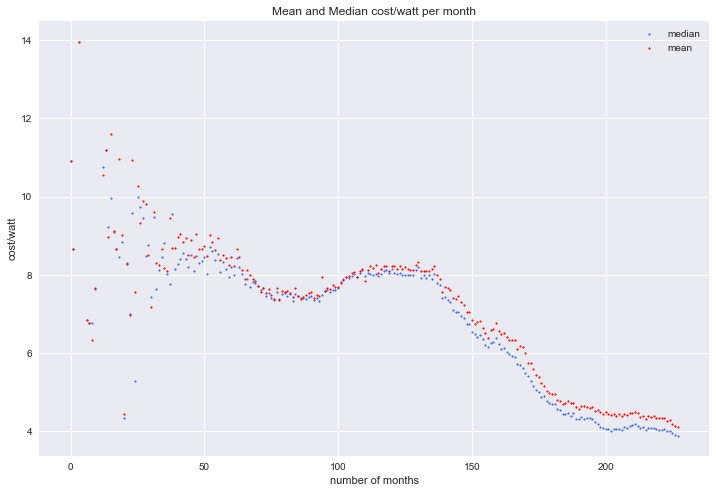

In [44]:
by_month = dfMod.groupby(['num_months'])
med_month = by_month.cost_per_watt.median()
mean_month = by_month.cost_per_watt.mean()

# print(med_month.head())

fig, ax = plt.subplots(figsize=(12, 8))
sTitle = 'Mean and Median cost/watt per month'

ax.set_title(sTitle)
ax.scatter(med_month.index, med_month, marker='.', color='royalblue', s=12, alpha=1.0, label='median')
ax.scatter(mean_month.index, mean_month, marker='.', color='red', s=12, alpha=1.0, label='mean')
ax.set_ylabel('cost/watt')
ax.set_xlabel('number of months')
ax.legend()

plt.show();

In [14]:
np.var(med_month), np.std(med_month)

(3.22558947367301, 1.7959926151499093)

---
---

#### Model median by months first; it will be the fastest.  It turns out with one variable all time frames are very fast to fit.

In [15]:
# Setup the pipeline steps
steps = [('scaler', StandardScaler()),
         ('poly', PolynomialFeatures()),
         ('LR', LinearRegression())]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

In [16]:
pipeline.get_params()

{'memory': None,
 'steps': [('scaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('poly',
   PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)),
  ('LR',
   LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))],
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'poly': PolynomialFeatures(degree=2, include_bias=True, interaction_only=False),
 'LR': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'poly__degree': 2,
 'poly__include_bias': True,
 'poly__interaction_only': False,
 'LR__copy_X': True,
 'LR__fit_intercept': True,
 'LR__n_jobs': 1,
 'LR__normalize': False}

In [17]:
med_month.head()

num_months
0.0    10.921508
1.0     8.667013
3.0    13.962563
6.0     6.858942
7.0     6.768190
Name: cost_per_watt, dtype: float64

In [18]:
X = med_month.index.values.reshape(-1, 1)
y = med_month.values.reshape(-1, 1)
print(X[:5], y[:5])

[[0.]
 [1.]
 [3.]
 [6.]
 [7.]] [[10.9215]
 [ 8.667 ]
 [13.9626]
 [ 6.8589]
 [ 6.7682]]


In [19]:
# we want to search and plot separately

# want to plot both R2 and RMSE
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Create the hyperparameter grid, just poly degree
poly_space = np.arange(1, 21)
param_grid = {'poly__degree': poly_space}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=21)

# build the scoring map
scoring = {'Rsquared': 'r2',
           'RMSE': make_scorer(RMSE, greater_is_better=False) }

# Create the GridSearchCV object: gs_cv
gs_cv = GridSearchCV(pipeline, param_grid, cv=3, scoring=scoring, 
                     return_train_score=True, refit='Rsquared')

# Fit best model to the training set
gs_cv.fit(X_train, y_train)

# Score the model in the test set
theR2 = gs_cv.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("test R squared: {}".format(theR2))

# uncomment to see results ds
# gs_cv.cv_results_

Best parameters: {'poly__degree': 13}
test R squared: 0.747614723188011


Best parameters: {'poly__degree': 13}
R squared with best parameters: 0.747614723188011


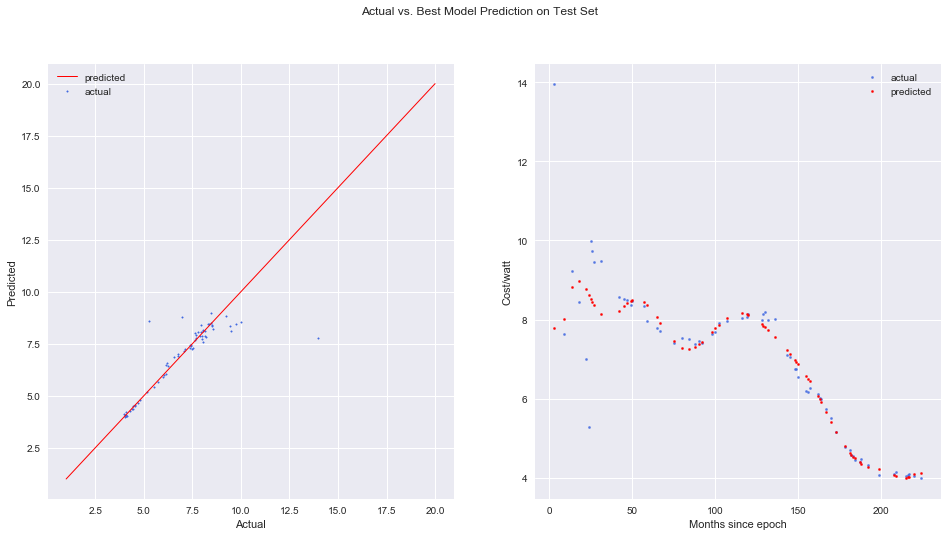

In [20]:
# Show R2
theR2 = gs_cv.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("R squared with best parameters: {}".format(theR2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Actual vs. Best Model Prediction on Test Set')

ax1.scatter(y_test, gs_cv.predict(X_test), marker='.', s=10, color='royalblue', alpha=1, label='actual')
ax1.plot(np.array([1,20]), np.array([1,20]), linewidth=1, color='red', label='predicted')
ax1.set_ylabel('Predicted')
ax1.set_xlabel('Actual')
ax1.legend()

ax2.scatter(X_test[:, 0], y_test, marker='.', color='royalblue', s=20, alpha=0.9, label='actual')
ax2.scatter(X_test[:, 0], gs_cv.predict(X_test), marker='.', color='red', s=20, alpha=1, label='predicted')
ax2.set_ylabel('Cost/watt')
ax2.set_xlabel('Months since epoch')
ax2.legend()

plt.show();

### This shows what a high degree polynomial (and not much data) will do.  It fits the cross-val tests and actual test set well but is very unstable for extrapolation.

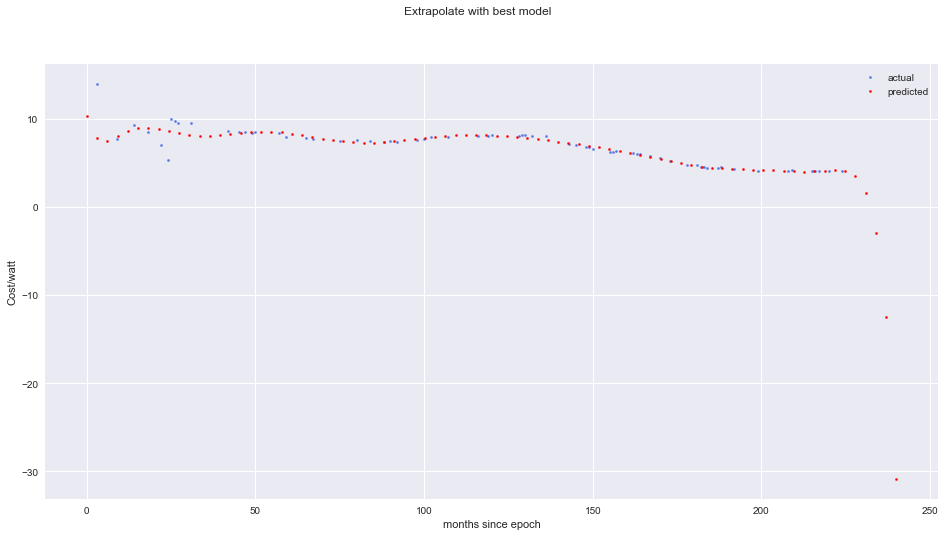

In [21]:
fig, ax = plt.subplots(figsize=(16, 8))
fig.suptitle('Extrapolate with best model')

X_future = np.linspace(0.0, 240, 80).reshape(-1,1)
ax.scatter(X_test[:,0], y_test, marker='.', color='royalblue', s=20, alpha=0.9, label='actual')
ax.scatter(X_future, gs_cv.predict(X_future), marker='.', color='red', s=20, alpha=1, label='predicted')
ax.set_ylabel('Cost/watt')
ax.set_xlabel('months since epoch')
ax.legend();

In [22]:
def trainVsTestResults(results): 
    ''' Plot test/train results for R^2 and RMSE'''    

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    sTitle = 'mean cross-validation train/test RMSE and R^2 vs poly degree'
    fig.suptitle(sTitle)
          
    mean_train_RMSE = results['mean_train_RMSE']
    mean_test_RMSE = results['mean_test_RMSE']
    n = len(mean_train_RMSE)
        
    ax1.plot(np.arange(1, n + 1), np.abs(mean_train_RMSE), marker='d', ms=15, alpha=0.5, color='green', label='train');
    ax1.plot(np.arange(1, n + 1), np.abs(mean_test_RMSE), marker='*', ms=10, alpha=1.0, color='red', label='test');
    ax1.set_ylabel('RMSE')
    ax1.set_xlabel('polynomial degree')
    ax1.set_title('mean train/test RMSE vs poly degree')
    ax1.legend()
    
    mean_train_R2 = results['mean_train_Rsquared']
    mean_test_R2 = results['mean_test_Rsquared']
    n = len(mean_train_R2)
    
    fig.suptitle(sTitle.format(gs_cv.best_params_))

    ax2.plot(np.arange(1, n + 1), np.abs(mean_train_R2), marker='d', ms=15, alpha=0.5, color='green', label='train');
    ax2.plot(np.arange(1, n + 1), np.abs(mean_test_R2), marker='*', ms=10, color='red', label='test');
    ax2.set_ylabel('R^2')
    ax2.set_xlabel('polynomial degree')
    ax2.set_title('mean train/test R2 vs poly degree')
    ax2.legend()
          
    r2 = gs_cv.score(X_test, y_test)
    print("Best parameters: {}".format(gs_cv.best_params_))
    print("Best parameters test R squared: {}".format(r2))

Best parameters: {'poly__degree': 13}
Best parameters test R squared: 0.747614723188011


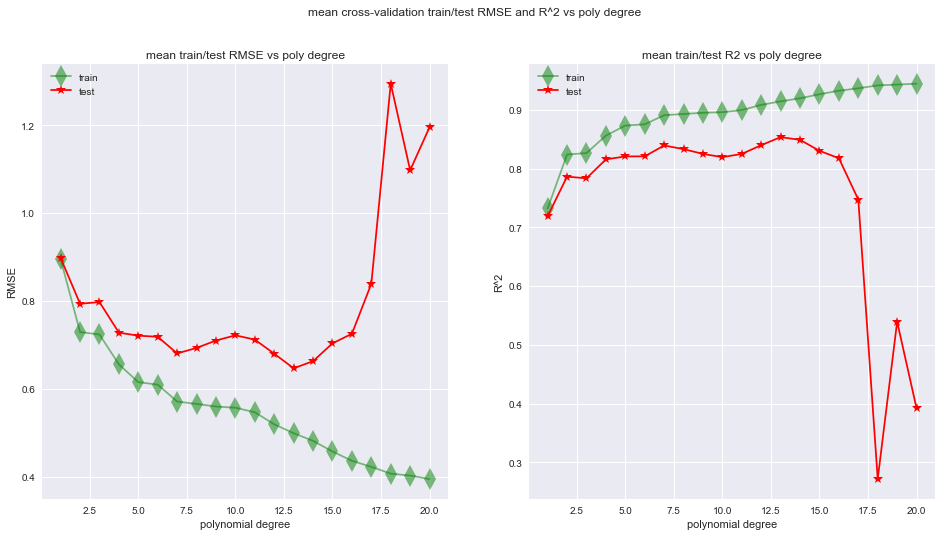

In [23]:
trainVsTestResults(gs_cv.cv_results_)

#### Odd result here.  A lot of the the cross validation train/test scores are higher than 'best' model score on test set.  Doesn't seem like that should happen.  It might be the case that since the number of months is pretty small (~220), there's not enough data to make this very flexible estimator behave.

__====================================================================================================================__

### Model median by week

In [24]:
num_weeks = (med_week.index - med_week.index[0]).values.astype(np.float); num_weeks[:5]

array([ 0.,  3.,  4., 12., 16.])

In [25]:
med_week[:5]

num_weeks
0.0    10.734315
3.0    11.108701
4.0     8.667013
Name: cost_per_watt, dtype: float64

In [26]:
med_week.head()

num_weeks
0.0     10.734315
3.0     11.108701
4.0      8.667013
12.0    13.270286
16.0    14.654839
Name: cost_per_watt, dtype: float64

In [27]:
X = med_week.index.values.reshape(-1,1)
y = med_week.values.reshape(-1,1)

In [28]:
# we want to search and plot separately

# want to plot both R2 and RMSE
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Create the hyperparameter grid, just poly degree
poly_space = np.arange(1, 15)
param_grid = {'poly__degree': poly_space}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=21)

# build the scoring map
scoring = {'Rsquared': 'r2',
           'RMSE': make_scorer(RMSE, greater_is_better=False) }

# Create the GridSearchCV object: gs_cv
gs_cv = GridSearchCV(pipeline, param_grid, cv=3, scoring=scoring, 
                     return_train_score=True, refit='Rsquared')

# Fit to the training set
gs_cv.fit(X_train, y_train)

# Compute and print the metrics
theR2 = gs_cv.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("test R squared: {}".format(theR2))

# uncomment to see results ds
# gs_cv.cv_results_

Best parameters: {'poly__degree': 8}
test R squared: 0.8490815751507972


Best parameters: {'poly__degree': 8}
Best R squared: 0.8490815751507972


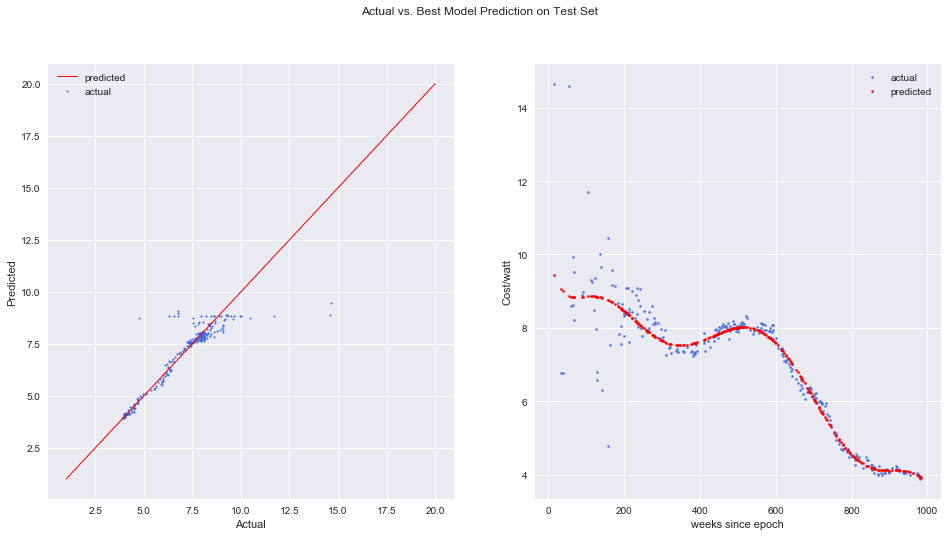

In [29]:
# Show R2
theR2 = gs_cv.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("Best R squared: {}".format(theR2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Actual vs. Best Model Prediction on Test Set')

ax1.scatter(y_test, gs_cv.predict(X_test), marker='.', s=10, color='royalblue', alpha=1, label='actual')
ax1.plot(np.array([1,20]), np.array([1,20]), linewidth=1, color='red', label='predicted')
ax1.set_ylabel('Predicted')
ax1.set_xlabel('Actual')
ax1.legend()

ax2.scatter(X_test[:, 0], y_test, marker='.', color='royalblue', s=20, alpha=0.9, label='actual')
ax2.scatter(X_test[:, 0], gs_cv.predict(X_test), marker='.', color='red', s=20, alpha=1, label='predicted')
ax2.set_ylabel('Cost/watt')
ax2.set_xlabel('weeks since epoch')
ax2.legend()

plt.show();

In [30]:
# weeks/weeks per year
1100/52

21.153846153846153

In [31]:
(X[-1] + 104)/13

array([84.1538])

### Extrapolate weeks.  Predict every 13 weeks.

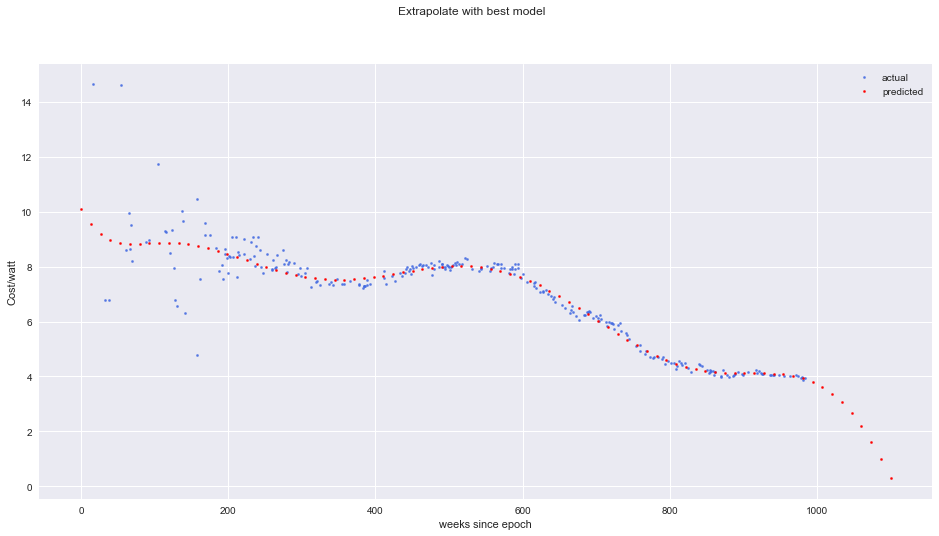

In [32]:
fig, ax = plt.subplots(figsize=(16, 8))
fig.suptitle('Extrapolate with best model')

X_future = np.linspace(0.0, 1100, 84).reshape(-1,1)
ax.scatter(X_test[:,0], y_test, marker='.', color='royalblue', s=20, alpha=0.9, label='actual')
ax.scatter(X_future, gs_cv.predict(X_future), marker='.', color='red', s=20, alpha=1, label='predicted')
ax.set_ylabel('Cost/watt')
ax.set_xlabel('weeks since epoch')
ax.legend();

Best parameters: {'poly__degree': 8}
Best parameters test R squared: 0.8490815751507972


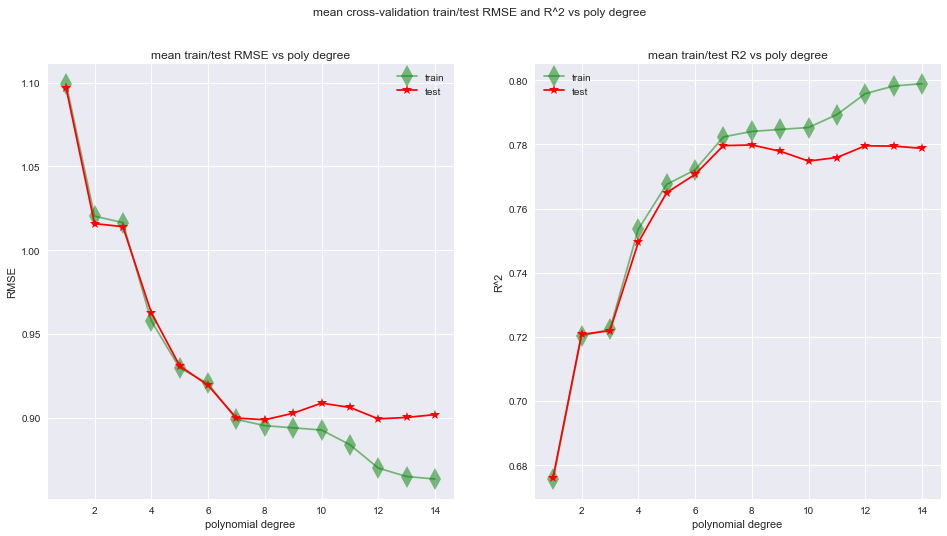

In [33]:
trainVsTestResults(gs_cv.cv_results_)

#### This is actually pretty rockin' performance.  Notice that 'best' model on test set has $better$ $R^2$ than we see in the cross-validation.  More data helps.  The prediction is reasonable enough to be usable.

__=========================================================================================================================__

### Now daily medians

In [34]:
med_date.head()

num_days
0.0      10.734315
21.0     11.108701
26.0      8.667013
84.0     13.270286
111.0    14.654839
Name: cost_per_watt, dtype: float64

In [35]:
X = med_date.index.values.reshape(-1, 1)
y = med_date.values.reshape(-1, 1)

In [36]:
# we want to search and plot separately

# want to plot both R2 and RMSE
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Create the hyperparameter grid, just poly degree
poly_space = np.arange(1, 12)
param_grid = {'poly__degree': poly_space}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=21)

# build the scoring map
scoring = {'Rsquared': 'r2',
           'RMSE': make_scorer(RMSE, greater_is_better=False) }

# Create the GridSearchCV object: gs_cv
gs_cv = GridSearchCV(pipeline, param_grid, cv=3, scoring=scoring, 
                     return_train_score=True, refit='Rsquared')

# Fit to the training set
gs_cv.fit(X_train, y_train)

# Compute and print the metrics
theR2 = gs_cv.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("test R squared: {}".format(theR2))

# uncomment to see results ds
# gs_cv.cv_results_

Best parameters: {'poly__degree': 8}
test R squared: 0.752662846034723


Best parameters: {'poly__degree': 8}
Best R squared: 0.752662846034723


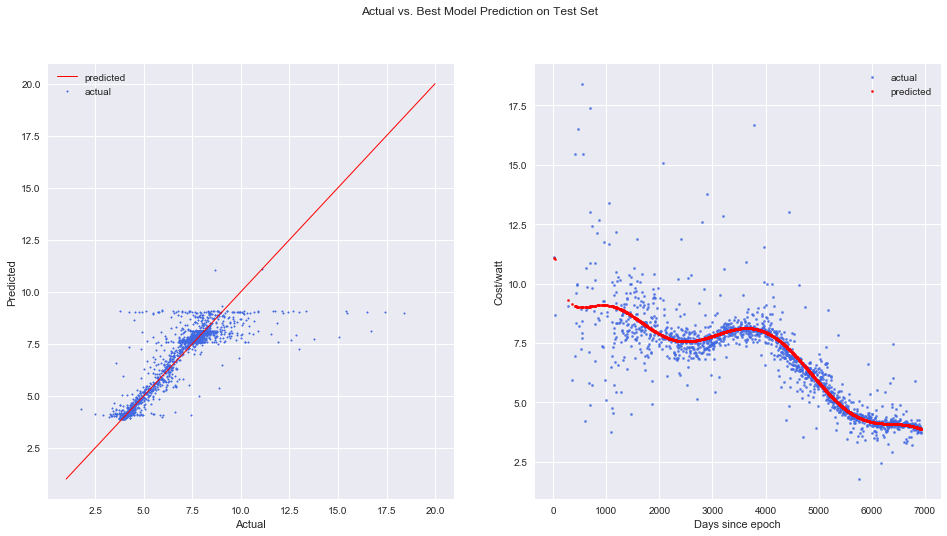

In [37]:
# Show R2
theR2 = gs_cv.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("Best R squared: {}".format(theR2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Actual vs. Best Model Prediction on Test Set')

ax1.scatter(y_test, gs_cv.predict(X_test), marker='.', s=10, color='royalblue', alpha=1, label='actual')
ax1.plot(np.array([1,20]), np.array([1,20]), linewidth=1, color='red', label='predicted')
ax1.set_ylabel('Predicted')
ax1.set_xlabel('Actual')
ax1.legend()

ax2.scatter(X_test[:, 0], y_test, marker='.', color='royalblue', s=20, alpha=0.9, label='actual')
ax2.scatter(X_test[:, 0], gs_cv.predict(X_test), marker='.', color='red', s=20, alpha=1, label='predicted')
ax2.set_ylabel('Cost/watt')
ax2.set_xlabel('Days since epoch')
ax2.legend()

plt.show();

In [38]:
7700/(13*7)

84.61538461538461

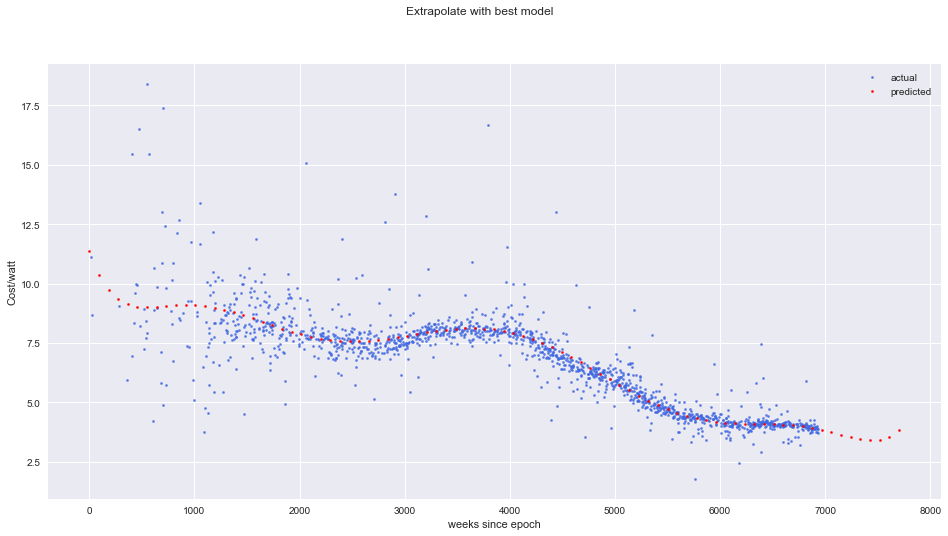

In [39]:
fig, ax = plt.subplots(figsize=(16, 8))
fig.suptitle('Extrapolate with best model')

X_future = np.linspace(0.0, 7700, 85).reshape(-1,1)
ax.scatter(X_test[:,0], y_test, marker='.', color='royalblue', s=20, alpha=0.9, label='actual')
ax.scatter(X_future, gs_cv.predict(X_future), marker='.', color='red', s=20, alpha=1, label='predicted')
ax.set_ylabel('Cost/watt')
ax.set_xlabel('weeks since epoch')
ax.legend();

Best parameters: {'poly__degree': 8}
Best parameters test R squared: 0.752662846034723


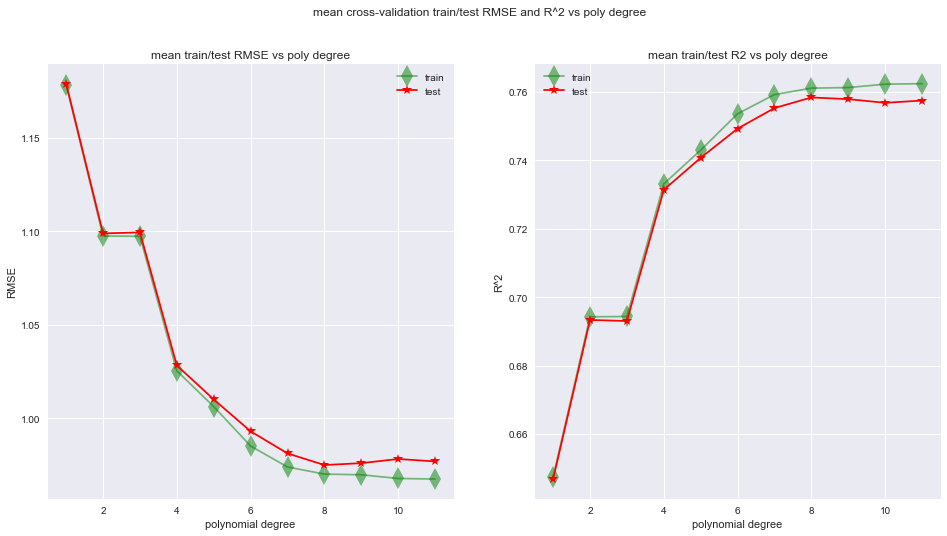

In [40]:
trainVsTestResults(gs_cv.cv_results_)

#### This is very similar to weekly mean (but with more noise).  RSME of best model well under \$1.00.  Prediction tail is a bit funky, but it looks good for 6 quarters.

---